In [1]:
import json, os, sys

from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
    
import utils
import result_helper

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_results_dir = Path("../data/experiments-skadi/")
job_paths = list(data_results_dir.glob("**/job-info.json"))

In [4]:
df_data = result_helper.get_result_summary(job_paths)

In [5]:
df_plot_data = df_data.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])
cols_to_drop = [
    "started_at", "completed_at", "precision_score", "recall_score", "f1_score", "random_seed",
    'experiment_type', 'experiment_name', 'component_size', 'variance', 'label_noise_proba',
    'allow_self_loops', 'distance_metric',
]
df_plot_data = df_plot_data.drop(cols_to_drop, axis=1)

In [6]:
df_plot_data

,accuracy_score,n_dim,min_distance,n_steps,bias_factor,duration_secs,job_path
435,0.276680,10,2,1,1,3.002293,../data/experiments-skadi/rwe/dim_dist_steps_b...
426,0.376000,10,2,5,1,3.082817,../data/experiments-skadi/rwe/dim_dist_steps_b...
180,0.392000,10,2,10,1,3.767190,../data/experiments-skadi/rwe/dim_dist_steps_b...
436,0.257888,10,2,25,1,3.708549,../data/experiments-skadi/rwe/dim_dist_steps_b...
222,0.173258,10,2,75,1,5.239929,../data/experiments-skadi/rwe/dim_dist_steps_b...
...,...,...,...,...,...,...,...
217,0.245935,150,6,25,5,27983.083854,../data/experiments-skadi/rwe/dim_dist_steps_b...
147,0.214498,150,6,1,10,3327.836077,../data/experiments-skadi/rwe/dim_dist_steps_b...
425,0.259159,150,6,5,10,8054.531549,../data/experiments-skadi/rwe/dim_dist_steps_b...
94,0.209761,150,6,10,10,12367.776051,../data/experiments-skadi/rwe/dim_dist_steps_b...


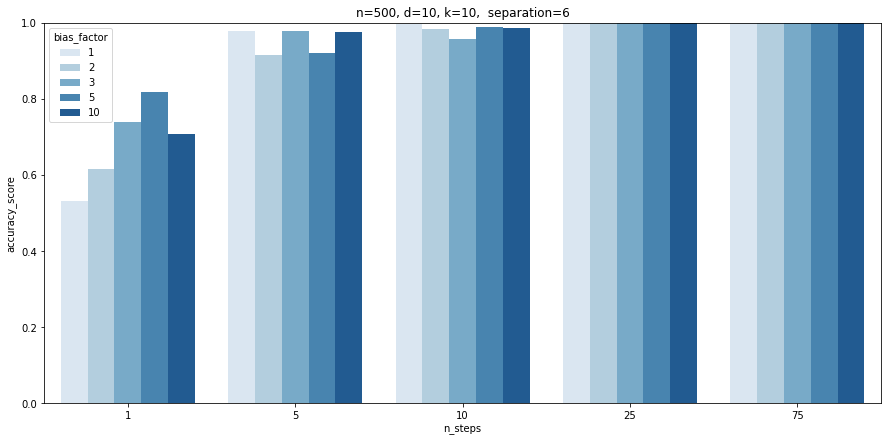

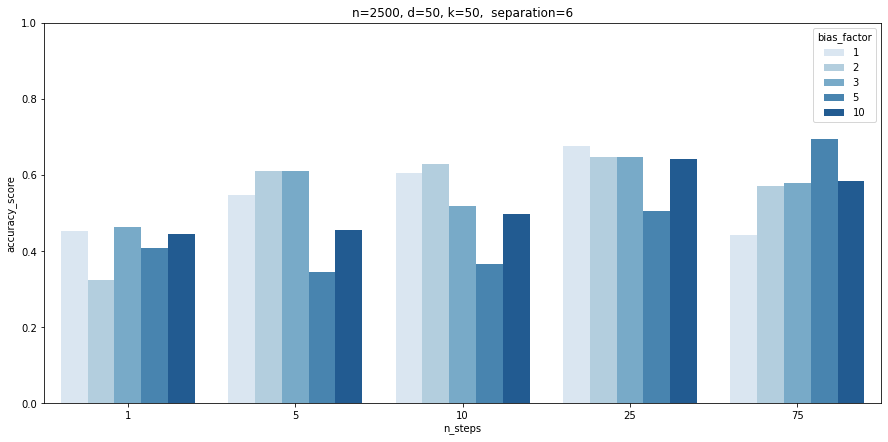

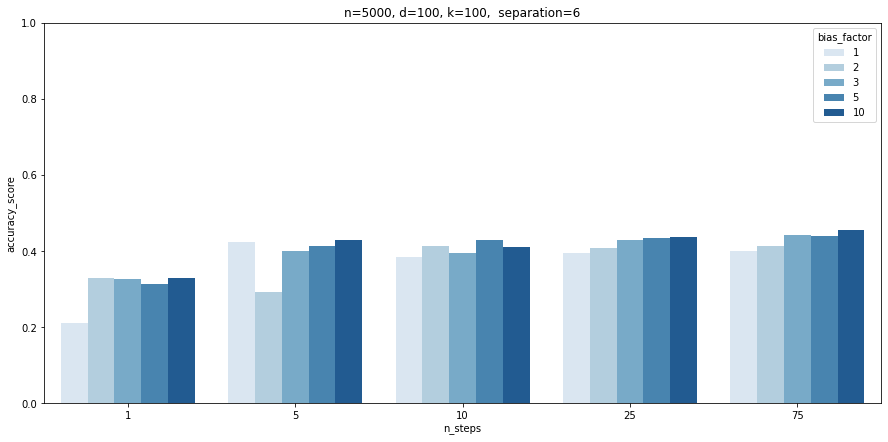

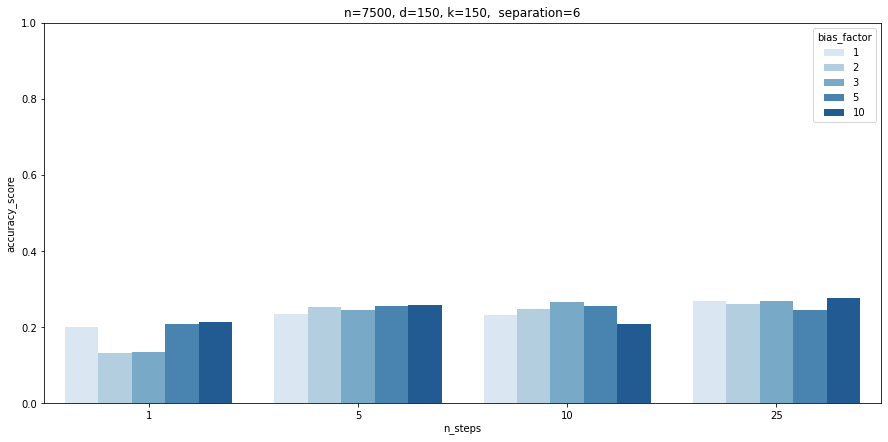

In [7]:
for n_dim in [10, 50, 100, 150]:
    for min_distance in [6]:
        df_plot_data_filtered = df_plot_data[ (df_plot_data.n_dim == n_dim) & (df_plot_data.min_distance == min_distance) ]
        fig, ax = plt.subplots(figsize=(15, 7))
        sns.barplot(
            x="n_steps",
            y="accuracy_score",
            hue="bias_factor", 
            data=df_plot_data_filtered,
            palette="Blues",
            ax=ax,
        )
        ax.set_title(f"n={n_dim*50}, d={n_dim}, k={n_dim},  separation={min_distance}");
        ax.set_ylim([0, 1])